# Imports

In [1]:
# import libraries
import pandas as pd
from math import exp
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score

## 1. Data Cleaning

In [2]:
county_jail_df = pd.read_csv('County_Jail.csv')
county_jail_df.head()

,Unnamed: 0,reporting_jurisdictions,county_name,state_name,Date,jail_population
0,0,Whitman County Jail,Whitman County,WA,2020-06-12,26
1,1,Adams County Jail,Adams County,WA,2020-06-12,22
2,2,Clallam County Jail,Clallam County,WA,2020-06-12,74
3,3,Ferry County Corrections,Ferry County,WA,2020-06-12,8
4,4,Grays Harbor County Jail,Grays Harbor County,WA,2020-06-12,172


In [3]:
county_jail_df.shape

(129, 6)

In [4]:
vera_df = pd.read_csv('https://raw.githubusercontent.com/vera-institute/jail-population-data/master/jail_population.csv')
vera_df.head()

,fips,date,jail_population,county_name,state_name,urbanicity,reporting_jurisdictions,resident_population,jail_incarceration_rate_per_100k
0,1001,2020-01-01,185,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,331.1
1,1001,2020-01-02,184,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,329.3
2,1001,2020-01-03,178,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,318.6
3,1001,2020-01-04,177,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,316.8
4,1001,2020-01-05,183,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,327.6


In [17]:
# hist_vera_df=pd.read_csv('https://raw.githubusercontent.com/vera-institute/incarceration_trends/master/incarceration_trends.csv')
# death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [29]:
nytimes_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
nytimes_df.head()
# nytimes_df.shape

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [55]:
#Need to convert to datetime column
nytimes_df['date']=pd.to_datetime(nytimes_df['date'], errors='coerce')
vera_df['date']=pd.to_datetime(vera_df['date'], errors='coerce')

#Fips as same data type
vera_df['fips']=vera_df['fips'].astype(float)

In [56]:
vera_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225820 entries, 0 to 225819
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   fips                              225820 non-null  float64       
 1   date                              225820 non-null  datetime64[ns]
 2   jail_population                   225820 non-null  int64         
 3   county_name                       225713 non-null  object        
 4   state_name                        225626 non-null  object        
 5   urbanicity                        225713 non-null  object        
 6   reporting_jurisdictions           223258 non-null  object        
 7   resident_population               225713 non-null  float64       
 8   jail_incarceration_rate_per_100k  225713 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 15.5+ MB


In [54]:
nytimes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310256 entries, 0 to 310255
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    310256 non-null  datetime64[ns]
 1   county  310256 non-null  object        
 2   state   310256 non-null  object        
 3   fips    307024 non-null  float64       
 4   cases   310256 non-null  int64         
 5   deaths  310256 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 14.2+ MB


In [72]:
combo_df = pd.concat([vera_df, nytimes_df], keys=['date', 'fips'],ignore_index=True,copy=False)

combo_df.head()

,fips,date,jail_population,county_name,state_name,urbanicity,reporting_jurisdictions,resident_population,jail_incarceration_rate_per_100k,county,state,cases,deaths
0,1001.0,2020-01-01,185.0,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,331.1,NaN,NaN,NaN,NaN
1,1001.0,2020-01-02,184.0,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,329.3,NaN,NaN,NaN,NaN
2,1001.0,2020-01-03,178.0,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,318.6,NaN,NaN,NaN,NaN
3,1001.0,2020-01-04,177.0,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,316.8,NaN,NaN,NaN,NaN
4,1001.0,2020-01-05,183.0,Autauga County,Alabama,small/mid,Autauga Metro Jail,55869.0,327.6,NaN,NaN,NaN,NaN


In [73]:
combo_df.shape

(536076, 13)

In [76]:
google_df = pd.read_csv('Global_Mobility_Report.csv')
google_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [77]:
# https://github.com/kjhealy/fips-codes

## 2. EDA

KeyError: "None of [Index(['cases'], dtype='object')] are in the [columns]"

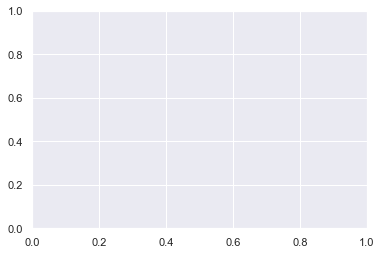

In [65]:
combo_df.boxplot('cases')

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

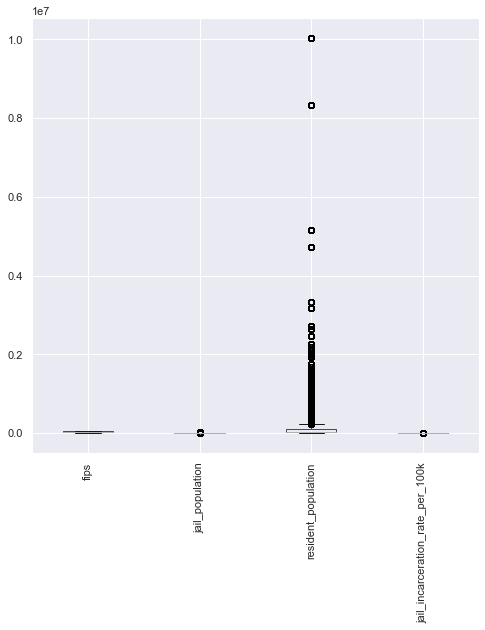

In [66]:
pd.DataFrame.boxplot(combo_df,figsize=(8,8))
plt.xticks(rotation=90)

## 3. Feature Engineering

In [46]:
combo_df.columns

Index(['fips', 'date', 'jail_population', 'county_name', 'state_name',
       'urbanicity', 'reporting_jurisdictions', 'resident_population',
       'jail_incarceration_rate_per_100k', 'county', 'state', 'cases',
       'deaths'],
      dtype='object')

In [47]:
combo_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 536076 entries, ('date', 0) to ('fips', 310255)
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fips                              532844 non-null  float64
 1   date                              536076 non-null  object 
 2   jail_population                   225820 non-null  float64
 3   county_name                       225713 non-null  object 
 4   state_name                        225626 non-null  object 
 5   urbanicity                        225713 non-null  object 
 6   reporting_jurisdictions           223258 non-null  object 
 7   resident_population               225713 non-null  float64
 8   jail_incarceration_rate_per_100k  225713 non-null  float64
 9   county                            310256 non-null  object 
 10  state                             310256 non-null  object 
 11  cases                           

In [67]:
corrmat = combo_df[['cases','deaths','jail_incarceration_rate_per_100k']].corr()

sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

KeyError: "['cases', 'deaths'] not in index"

In [43]:
# X = df.drop(['DEFAULT'],axis=1)
# y = df['DEFAULT']

# X.corrwith(df['DEFAULT']).plot.bar(
#         figsize = (20, 10), title = "Correlation with Default", fontsize = 20,
#         rot = 90, grid = True)

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [18]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [19]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Logistic Regression

In [20]:
# Create intercept term
X = sm.add_constant(X)

# Fit model
logit_model = sm.Logit(y, X)

# Get results of the fit
result = logit_model.fit()

         Current function value: 0.464375
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X, y)
model_log

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### KNN

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [23]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [25]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [26]:
# make class predictions for the testing set
y_pred_class = knn.predict(X_test)

In [27]:
# calculate accuracy
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1:' + str(metrics.f1_score(y_test, y_pred_class)))

Accuracy:0.7316666666666667
F1:0.37402799377916013


## Final Model: XGBoost

In [28]:
df['DEFAULT'].value_counts()

0    18690
1     5308
Name: DEFAULT, dtype: int64

In [29]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [31]:
training = pd.concat([X_train,y_train], axis =1)

In [32]:
ndefault = training[training['DEFAULT']==0]
default = training[training['DEFAULT']==1]

In [33]:
upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(ndefault), # match number in majority class
                          random_state=23) # reproducible results

upsampled = pd.concat([ndefault, upsampled])
upsampled['DEFAULT'].value_counts()

1    14032
0    14032
Name: DEFAULT, dtype: int64

In [34]:
upsampled

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,education_2,education_3,education_4,education_5,education_6,marriage_0,marriage_1,marriage_2,marriage_3,DEFAULT
18610,380000,2,33,1,1,2,2,2,2,363944,...,1,0,0,0,0,0,1,0,0,0
15020,250000,2,29,0,0,0,0,0,0,180056,...,1,0,0,0,0,0,1,0,0,0
15875,120000,2,37,-2,-2,-2,-2,-2,-1,874,...,1,0,0,0,0,0,0,1,0,0
13456,490000,1,41,1,2,0,0,0,0,230090,...,0,0,0,0,0,0,1,0,0,0
1891,320000,2,47,-1,-1,2,-1,2,-1,10159,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20292,60000,1,36,-1,2,2,-1,-1,-2,780,...,0,0,0,0,0,0,0,1,0,1
21411,50000,2,31,0,0,0,2,0,0,45074,...,1,0,0,0,0,0,1,0,0,1
20147,20000,1,48,-1,0,-1,-1,2,0,1522,...,0,1,0,0,0,0,1,0,0,1
19840,330000,2,27,0,0,0,0,2,2,322464,...,0,0,0,0,0,0,0,1,0,1


In [35]:
# ndefault = df[df['DEFAULT']==0]
# default = df[df['DEFAULT']==1]

# upsampled = resample(default,
#                           replace=True, # sample with replacement
#                           n_samples=len(ndefault), # match number in majority class
#                           random_state=23) # reproducible results

# upsampled = pd.concat([ndefault, upsampled])
# upsampled['DEFAULT'].value_counts()

In [36]:
X_train = upsampled.drop('DEFAULT', axis = 1)
y_train = upsampled['DEFAULT']
feature_cols = X_train.columns

In [37]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'education_5',
       'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'],
      dtype='object')

In [38]:
xgb.XGBClassifier()
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.777500
F1: 0.466214


## TEST

In [39]:
test = pd.read_csv('hold_out_features.csv')

In [40]:
test.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,6320,240000,1,1,1,44,-1,-1,-1,...,2701,2427,1104,2362,2188,2701,2427,1104,2362,519
1,1,29659,50000,1,3,1,41,0,0,0,...,48468,39203,28913,26636,1816,1753,1433,990,967,1071
2,2,28347,20000,2,3,1,41,0,0,0,...,11583,13079,14546,16149,2000,1600,2000,2000,2000,2000
3,3,8523,320000,2,1,2,34,-2,-2,-2,...,-528,-1336,-1336,-1336,0,4,0,0,0,0
4,4,22135,120000,2,2,1,23,0,0,0,...,66825,68820,69776,71297,3000,2500,3100,2700,2800,2800


In [41]:
test.drop(columns = ['Unnamed: 0'], inplace = True)

In [42]:
education_dummies = pd.get_dummies(test['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(test['MARRIAGE'], prefix='marriage')
test = pd.concat([test, education_dummies, marriage_dummies], axis=1)
test.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
test.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'education_5',
       'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'],
      dtype='object')

In [43]:
final_results=xg_clf.predict(test)

ValueError: feature_names mismatch: ['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'] ['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3']
training data did not have the following fields: ID

In [ ]:
final_results=pd.Series(final_results)
final_results.to_csv('MR.csv', index=False)

In [ ]:
final_results.value_counts()

In [ ]:
# import pickle

# with open('MandR_Pickle.pickle','wb') as f:
#     pickle.dump(xg_clf, f)

### Notes: clean-up code for the project

In [ ]:
# def fit_predict(model1, x_train, y_train, test):
#     model.fit(x_train, y_train)
#     predictions = model.predict(test)
# print('Test Accuracy Score', accuracy_score(test, prediction))
# print('F1 Score', f1_score(test, prediction))
# return